# SIMULAÇAO DE GRAFOS

* Fernando Tancini - 1711799
* Andrea Mourelo - 1820000

In [319]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from networkx import *
import matplotlib.pyplot as plt
%matplotlib inline
import math
print('NetworkX version: {}'.format(nx.__version__))

NetworkX version: 2.2


## Population graph simulaton (some candidates)

## 1) Facebook data simulating comunitity and social net (Jogar isso fora, @Andrea?)

In [133]:
# carrega dados facebook
G_fb_no_data = nx.read_edgelist("data/facebook_combined.txt", create_using = nx.Graph(), nodetype = int)
spring_pos_for_G_fb = nx.spring_layout(G_fb_no_data)

def getNewFacebookNetwork():
    return nx.Graph(G_fb_no_data)

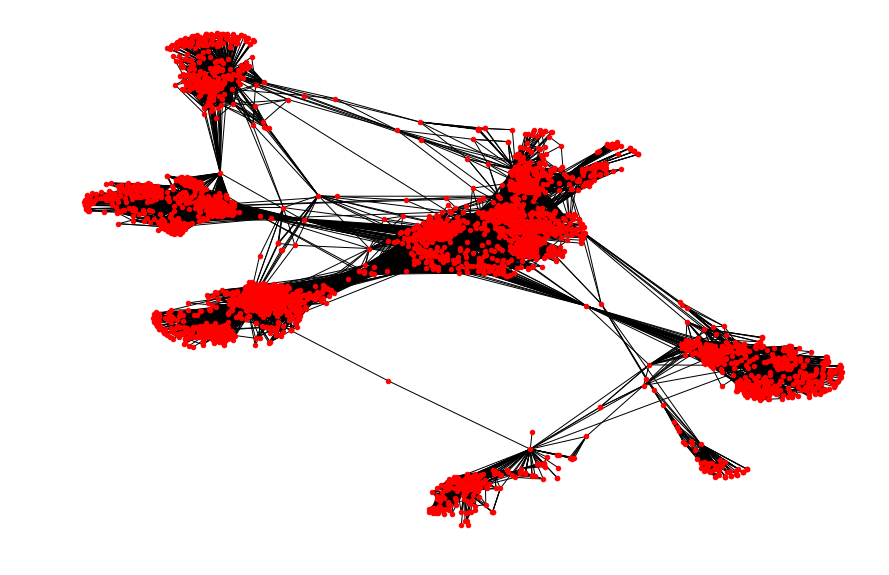

In [137]:
exemple_fb_graph = getNewFacebookNetwork()
plt.figure(figsize=(15,10))
plt.axis("off")
nx.draw_networkx(exemple_fb_graph, pos = spring_pos, with_labels = False, node_size = 20)

## Creating our graph generation for population simulation

In [393]:
# support functions
def rNormal(nsamples,mu,sigma2):
    x = np.zeros(nsamples)
    for i in range(nsamples):
        while(1):
            u1 = np.random.sample(1)
            y  = -math.log(u1)
            py = math.sqrt(2.0/math.pi)*math.exp(-0.5*y**2)
            hy = math.exp(-y)
            c  = math.sqrt(2.0*math.exp(1.0)/math.pi)
            u2 = np.random.sample(1)
            if (u2 <= py/(c*hy)):
                u3 = np.random.sample(1)
                if (u3 < 0.5):
                    x[i] = mu-math.sqrt(sigma2)*y
                else:
                    x[i] = mu+math.sqrt(sigma2)*y
                break
    return x

def rExponencial(nsamples,rate):
    x = np.zeros(nsamples)
    u = np.random.sample(nsamples)
    for i in range(nsamples):
        x[i] = - math.log(1.0-u[i])/rate
    return (x)

In [404]:
# @fernando @andrea, variar essas tres funções abaixo (achar outras distribuições também)
def generateNodePosX():
    return rNormal(1, 0, 100)[0]

def generateNodePosY():
    return rNormal(1, 5, 100)[0]

def generateMaxDistForBond():
    return rExponencial(1,0.5)[0]

def generatePopulationGraph(nNodes, attributes = {}):
    G = nx.Graph()

    # create the nodes
    # change the distribution probability here (@Fernando, @Andrea)
    for i in range(nNodes):
        pos  = (generateNodePosX(), generateNodePosY())
        G.add_node(i, pos = pos)
        
    # set the nodes attributes
    for key, value in attributes.items():
        for (p1_index, _) in G.nodes(data=True):
            G.nodes[p1_index][key] = value

    # create the bonds to all the nodes in a certaing range of distance
    # change the rolus for bond creating, for exemple: distribution probability = f(x) = 1/x
    for (p1_index, p1_data) in G.nodes(data=True):
        for (p2_index, p2_data) in G.nodes(data=True):
            Dist = np.sqrt((p1_data['pos'][1]-p2_data['pos'][1])**2+(p1_data['pos'][0]-p2_data['pos'][0])**2)
            if Dist <= generateMaxDistForBond():
                G.add_edge(p1_index,p2_index)

    # positioning the nodes according to their virtual position
    pos = {}
    for (n_index, n_data) in G.nodes(data=True):
        pos[n_index] = n_data['pos']

    return (G, pos)

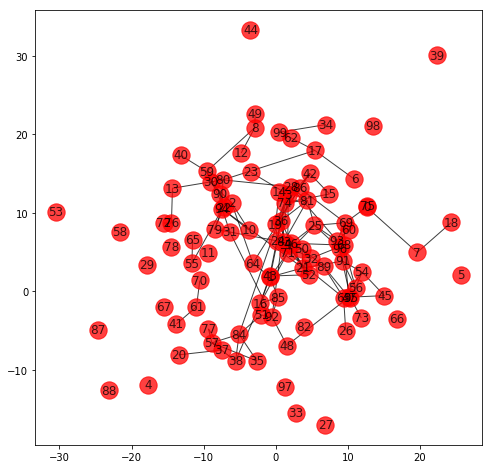

In [410]:
nNodes = 100
(exemple_graph, pos) = generatePopulationGraph(nNodes)
plt.figure(figsize=(8, 8))
nx.draw_networkx(exemple_graph,node_color='red',pos=pos, alpha=0.75)

## Simulating spread of disease

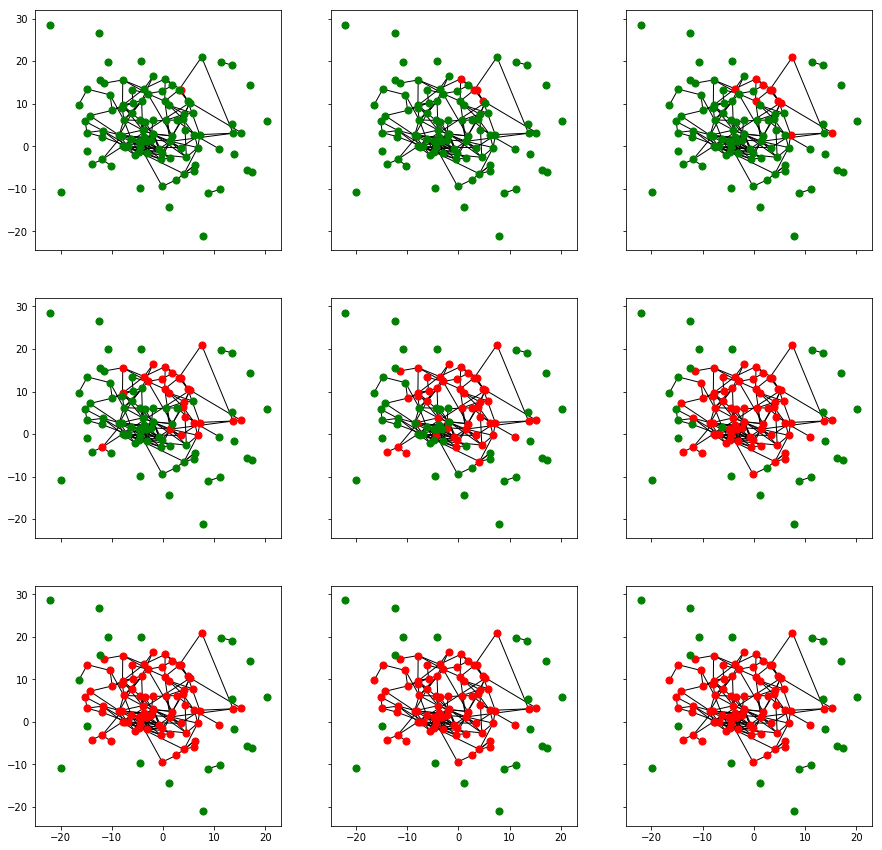

In [415]:
# Função usada para o set up da seed a cada função, pois se não não funcionava
seed_value = 1001004
    
def setNodeSick(G,node):
    # Makes the node "node" become sick
    G.node[node]['sick'] = 1 # becomes sick
    
def getDiseaseGroups(G):
    # Returns two lists, one with the sick nodes and the other with the healthy ones
    sick, notSick = [],[]
    sickness = nx.get_node_attributes(G, 'sick')
    for key,value in sickness.items():
        if (value == 0):
            notSick.append(key)
        else :
            sick.append(key)
    return sick, notSick

def propagateDisease(G,probaContagion):
    # With a probability probaContagion, propagates the disease (or not) to the neigbors of the sick people
    sick, notSick = getDiseaseGroups(G)
    for node in sick:
        for neigbor in G.neighbors(node):
            u = np.random.sample(1)[0]
            if (u < probaContagion):
                setDisease(G,neigbor)
    
def plotGraph(G,ax,pos):
    # Plots the evolution of the disease distribution
    sick,notSick = getDiseaseGroups(G)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=sick, node_size=50, node_color='red', ax=ax)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=notSick, node_size=50, node_color='green', ax=ax)
    #nx.draw_networkx_labels(G, pos=pos, labels={n: n for n in G.nodes()}, font_size=8, ax=ax)
    nx.draw_networkx_edges(G, pos=pos, ax=ax)
    #ax.set_axis_off() # Remove axes
    
def DiseaseExperience(people, experienceTime, probaContagion):
    
    # Setting the graph
    (G, pos) =  generatePopulationGraph(
                                        nNodes = people,
                                        attributes = {'sick': False},
                                       )

    # Setting the first sick person
    setNodeSick(G,39)
    
    # Plot settings
    nPlotsPerLine = 3
    nLines = int(experienceTime/nPlotsPerLine)
    fig, axes = plt.subplots(nLines, nPlotsPerLine, sharex=True, sharey=True, figsize = (15, 15))
    line_plot = 0
    
    # Evolution
    for second in range(time):
        plotGraph(G,axes[line_plot, second%3],pos)
        propagateDisease(G,probaContagion)
        if (second%3 == 2):
            line_plot += 1

people = 100
time = 9
probaContagion = 1
DiseaseExperience(people, time, probaContagion)

Ideas : 
    * Vary the probability of contagion
    * Vary the probability of having edges (relationships between people)
    * Vary the starting point of the disease
    * Create clusters (different cities?)
    * Do different states of sickness ( healthy, sick, recovery, sick again ?)

Interesting to read: 

TEORIA
http://www.est.ufmg.br/portal/arquivos/rts/RTE_01_2017.pdf
https://www.teses.usp.br/teses/disponiveis/100/100132/tde-04052015-091411/publico/fmoshecorrigida.pdf
https://www.ppgee.ufmg.br/defesas/350M.PDF (MENOS)


RANDOM GRAPH SIMULATION
https://graph-tool.skewed.de/static/doc/generation.html

EPIDEMYC
https://pyepydemic.readthedocs.io/en/latest/


exemplo civilizations
https://spyhce.com/blog/python-networkx-library
https://github.com/mihaigociu/myrepo/blob/master/networkx_presentation.py
